# Solar Panel Dust Detection

### 1.1 Introduction

There has been a tremendous growth in the use of solar panels as a form of generating electricity. Many industries are moving towards clean and renewable energy sources with one of them primarily from solar cells. In order for them to produce electricity with maximum efficiency, there is a higher need for regular maintenance. 

With data science and machine learning, it is possible to detect the dust accumulated in solar panels, ensuring that there is timely maintenance and improvement in accuracy. 

### 1.2 Data

The dataset was downloaded from Kaggle. It contains a list of images of solar panels that are clean and dusty in different directories. Below is the link to the repository where there is a detailed description of the images and the dataset. 

https://www.kaggle.com/datasets/hemanthsai7/solar-panel-dust-detection

### 1.3 Metrics

The dataset we are considering is quite balanced as there are equal number of images of clean and dusty solar panels. Therefore, we can use accuracy along with other metrics to evaluate the performance of deep learning models. 

1. Accuracy
2. Precision
3. Recall
4. F1-Score
5. AUC Score

## Table of Contents

#### 1.1 Introduction
#### 1.2 Data
#### 1.3 Metrics
#### 2.1 Reading the Libraries
#### 2.2 Defining the Path
#### 2.3 Exploratory Data Analysis (EDA)
#### 2.4 Splitting the Data
#### 2.5 Feature Engineering

&nbsp;&nbsp;&nbsp;&nbsp; *2.5.1 Normalization*

#### 2.6 Convolutional Neural Networks (CNNs)

&nbsp;&nbsp;&nbsp;&nbsp; *2.6.1 Training CNN Model (Configuration 1)*

&nbsp;&nbsp;&nbsp;&nbsp; *2.6.2 Training CNN Model (Configuration 2)*

&nbsp;&nbsp;&nbsp;&nbsp; *2.6.3 Training CNN Model (Configuration 3)*

&nbsp;&nbsp;&nbsp;&nbsp; *2.6.4 Training CNN Model (Configuration 4)*

#### 2.7 Transfer Learning

&nbsp;&nbsp;&nbsp;&nbsp; *2.7.1 VGG16 Network*

&nbsp;&nbsp;&nbsp;&nbsp; *2.7.2 VGG19 Network*

&nbsp;&nbsp;&nbsp;&nbsp; *2.7.3 InceptionNet*

&nbsp;&nbsp;&nbsp;&nbsp; *2.7.4 MobileNet*

&nbsp;&nbsp;&nbsp;&nbsp; *2.7.5 Xception Network*

&nbsp;&nbsp;&nbsp;&nbsp; *2.7.6 MobileNetV2*

&nbsp;&nbsp;&nbsp;&nbsp; *2.7.7 ResNet50*

#### 2.8 Hyperparameter Tuning

&nbsp;&nbsp;&nbsp;&nbsp; *2.8.1 Learning Rate*

&nbsp;&nbsp;&nbsp;&nbsp; *2.8.2 Batch Size*

#### 2.9 Saving the Best Model
#### 3. Summary



### 2.1 Reading the Libraries

In [1]:
# Importing the basic libraries to be used in the notebook
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import cv2
from tqdm import tqdm
from tensorflow.keras.applications import Xception, VGG16, VGG19
from tensorflow.keras.applications import InceptionV3, MobileNet, InceptionV3
import random
from tensorflow.keras.layers import Input, Dropout, Flatten, Dense
from tensorflow.keras.layers import AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import RMSprop
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50

import warnings
warnings.filterwarnings('ignore')
print("Is GPU Available: {}".format(tf.config.list_physical_devices('GPU')))

Is GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### 2.2 Defining the Path

In [2]:
# Defining the paths for the location where the images are stored
data_dir = 'Detect_solar_dust/'
clean_images_dir = data_dir + 'Clean'
dirty_images_dir = data_dir + 'Dusty'

In [3]:
# Defining universal variables to be used in coding cells below
random.seed(101)
SIZE = (224, 224)
BATCH_SIZE = 64
RANDOM_STATE = 101
GRAYSCALE = False
if GRAYSCALE == True:
    INPUT_SHAPE = SIZE + (1,)
else:
    INPUT_SHAPE = SIZE + (3,)

In [4]:
# Defining a function to load images
def load_images(directory, grayscale = GRAYSCALE, size = SIZE,
               use_augmented = True):
    
    destination_dir = directory + "_Discarded"
    if not os.path.exists(destination_dir):
        os.makedirs(destination_dir)
        
    images = []         # Creating a list to store the images in the form of array
    for filename in tqdm(os.listdir(directory)):
        if filename == "Augmented_images":
            continue
        img = cv2.imread(os.path.join(directory, filename), cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        try:
            height, width, _ = img.shape
            # move images with small dimenstions to the discarded folder
            if (height < 800 and width < 400 ) or (height < 400 and width < 800 ):
                shutil.move(os.path.join(directory, filename), os.path.join(destination_dir, filename))
                continue

            if grayscale:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = cv2.resize(img, size)
            x = np.array(img)
            x = np.expand_dims(x, axis=0)
            images.append(x)
        except Exception as e:
            continue
    
    if use_augmented:
        directory = os.path.join(directory, "Augmented_images")
        for filename in tqdm(os.listdir(directory)):
            img = cv2.imread(os.path.join(directory, filename), cv2.IMREAD_COLOR)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            try:
                height, width, _ = img.shape
                # move images with small dimenstions to the discarded folder
                if (height < 800 and width < 400 ) or (height < 400 and width < 800 ):
                    shutil.move(os.path.join(directory, filename), os.path.join(destination_dir, filename))
                    continue

                if grayscale:
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                img = cv2.resize(img, size)
                x = np.array(img)
                x = np.expand_dims(x, axis=0)
                images.append(x)
            except Exception as e:
                continue

    return images

In [5]:
# Defining a function to track the metrics such as accuracy, loss and roc-auc scores
def metrics_tracker(training_accuracy, cross_validation_accuracy,
                   trianing_loss, cross_validation_loss, y_test, y_predictions,
                   cmap = "Blues"):

    fig, axes = plt.subplots(2, 2, figsize = (10, 10))

    axes[0, 0].plot(training_accuracy, label = "Train Accuracy")
    axes[0, 0].plot(cross_validation_accuracy, label = "Cross-Validation Accuracy")
    axes[0, 0].set_title("Training Vs Cross-Validation Accuracy", fontsize = 10)
    axes[0, 0].set_xlabel("Epochs", fontsize = 10)
    axes[0, 0].set_ylabel("Accuracy", fontsize = 10)
    axes[0, 0].legend()
    axes[0, 0].grid(True)

    axes[0, 1].plot(training_loss, label = "Train Loss")
    axes[0, 1].plot(cross_validation_loss, label = "Cross-Validation Loss")
    axes[0, 1].set_title("Training Vs Cross-Validation Loss", fontsize = 10)
    axes[0, 1].set_xlabel("Epochs", fontsize = 10)
    axes[0, 1].set_ylabel("Loss", fontsize = 10)
    axes[0, 1].legend()
    axes[0, 1].grid(True)
    
    fpr, tpr, thresholds = roc_curve(y_test, y_predictions)
    roc_auc = auc(fpr, tpr)
    print(f"AUC for our classifier is: {roc_auc}")
    axes[1, 0].plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    axes[1, 0].plot([0, 1], [0, 1], 'k--')
    axes[1, 0].set_title("Receiver Operating Characteristics", fontsize = 10)
    axes[1, 0].set_xlabel("False Positive Rate", fontsize = 10)
    axes[1, 0].set_ylabel("True Positive Rate", fontsize = 10)
    axes[1, 0].set_xlim([0.0, 1.0])
    axes[1, 0].set_ylim([0.0, 1.05])
    axes[1, 0].legend()
    axes[1, 0].grid(True)

    sns.heatmap(confusion_matrix(y_predictions, y_test), annot = True,
               fmt = '.0f', ax = axes[1, 1], cmap = cmap)
    axes[1, 1].set_xlabel("Predicted Label", fontsize = 10)
    axes[1, 1].set_ylabel("Actual Label", fontsize = 10)
    axes[1, 1].set_title("Confusion Matrix", fontsize = 10)
    plt.tight_layout()
    plt.show()

    print("---------------------Classification Report---------------------")
    print(classification_report(y_predictions, y_test))

In [6]:
# Function used to convert probability outcomes to 0 or 1 respectively
def zero_one_classifier(predictions):
    y_predictions = []
    for prediction in predictions.reshape(1, -1)[0]:
        if prediction > 0.5:
            y_predictions.append(1)
        else:
            y_predictions.append(0)
    return y_predictions

In [7]:
# Loading the clean and dusty solar panel images from directories
# This can take about 2 minutes to run and load the images and convert them to array
clean_images_array = load_images(clean_images_dir, grayscale = GRAYSCALE)
dusty_images_array = load_images(dirty_images_dir, grayscale = GRAYSCALE)

100%|██████████████████████████████████████████████████████████████████████████████| 2460/2460 [00:52<00:00, 46.67it/s]


In [8]:
# Making changes to shape of clean and dusty solar panel images based on
# whether we are using grayscale image or colored images

if not GRAYSCALE:
    clean_images_array = np.array(np.squeeze(clean_images_array))
    dusty_images_array = np.array(np.squeeze(dusty_images_array))
else:
    clean_images_array = np.array(clean_images_array)
    dusty_images_array = np.array(dusty_images_array)
    clean_images_array = clean_images_array.reshape(len(clean_images_array), 224, 224, 1)
    dusty_images_array = dusty_images_array.reshape(len(dusty_images_array), 224, 224, 1)

### 2.3 Exploratory Data Analysis (EDA)

Exploratory data analysis (EDA) is an important step in machine learning where the dataset used is examined to check if there are any anomalies in the data. This would ensure that there are less inaccuraries in data for model predictions. 

In [9]:
print("The total number of images of clean solar panels: {}".format(len(clean_images_array)))
print("The total number of images of dusty solar panels: {}".format(len(dusty_images_array)))
print('-----------------------------------------------------')
print("The shape of images of clean solar panels: {}".format(clean_images_array.shape))
print("The shape of images of dusty solar panels: {}".format(dusty_images_array.shape))

The total number of images of clean solar panels: 4351
The total number of images of dusty solar panels: 2952
-----------------------------------------------------
The shape of images of clean solar panels: (4351, 224, 224, 3)
The shape of images of dusty solar panels: (2952, 224, 224, 3)


### Clean Solar Panel Images

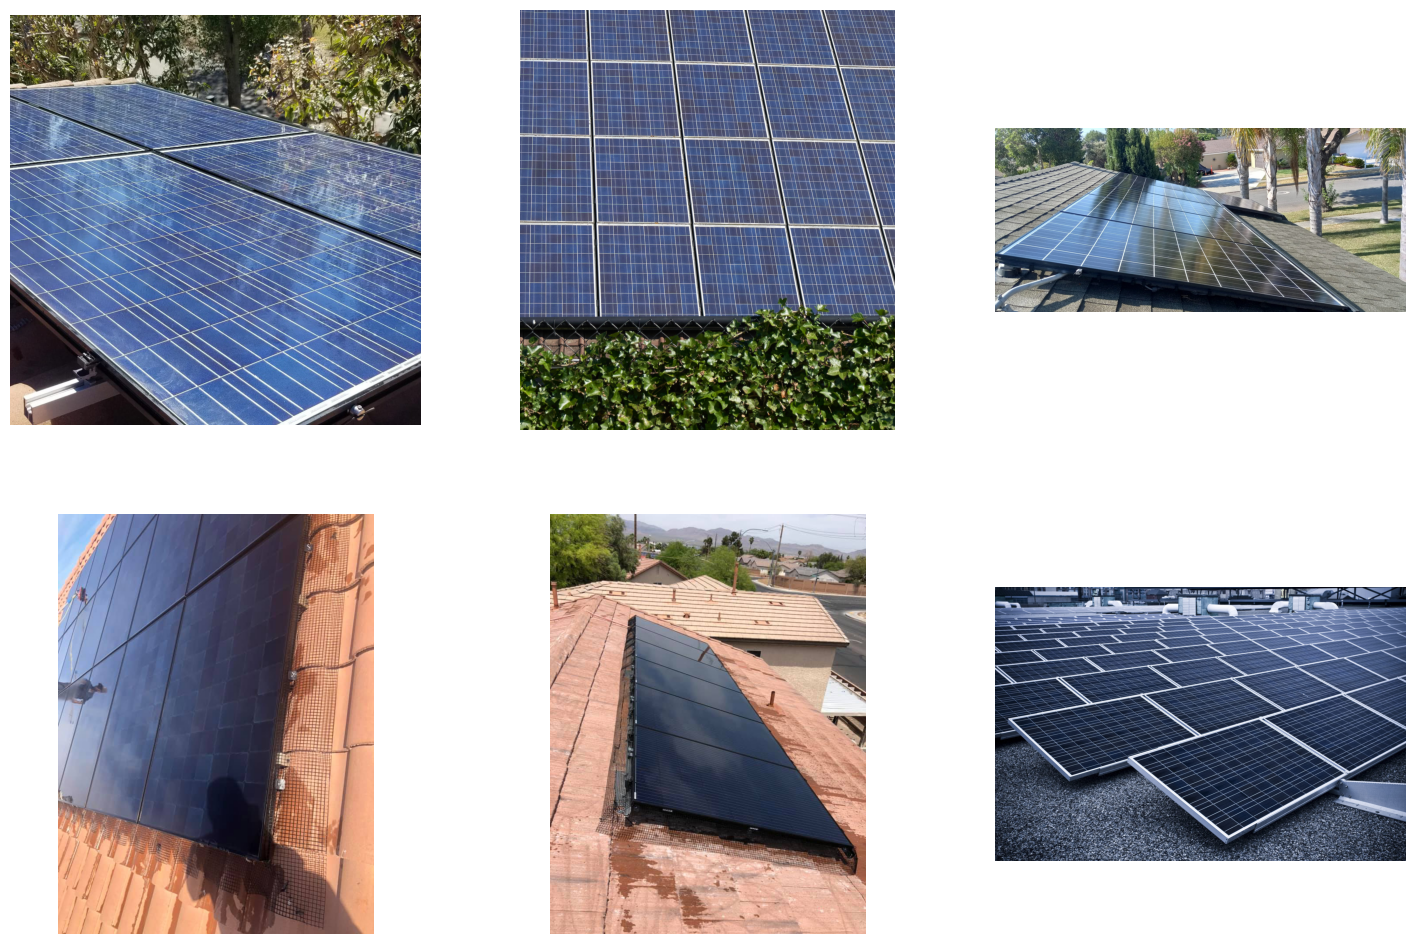

In [10]:
image_paths = os.listdir(clean_images_dir)
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))

# randomly select 6 images to display as big images
big_image_paths = random.sample(image_paths, 6)

for i, image_path in enumerate(big_image_paths):
    image = os.path.join(clean_images_dir, image_path)
    img = cv2.imread(image, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axs[i//3, i%3].imshow(img)
    axs[i//3, i%3].axis('off')

plt.show()

### Dusty Solar Panel Images

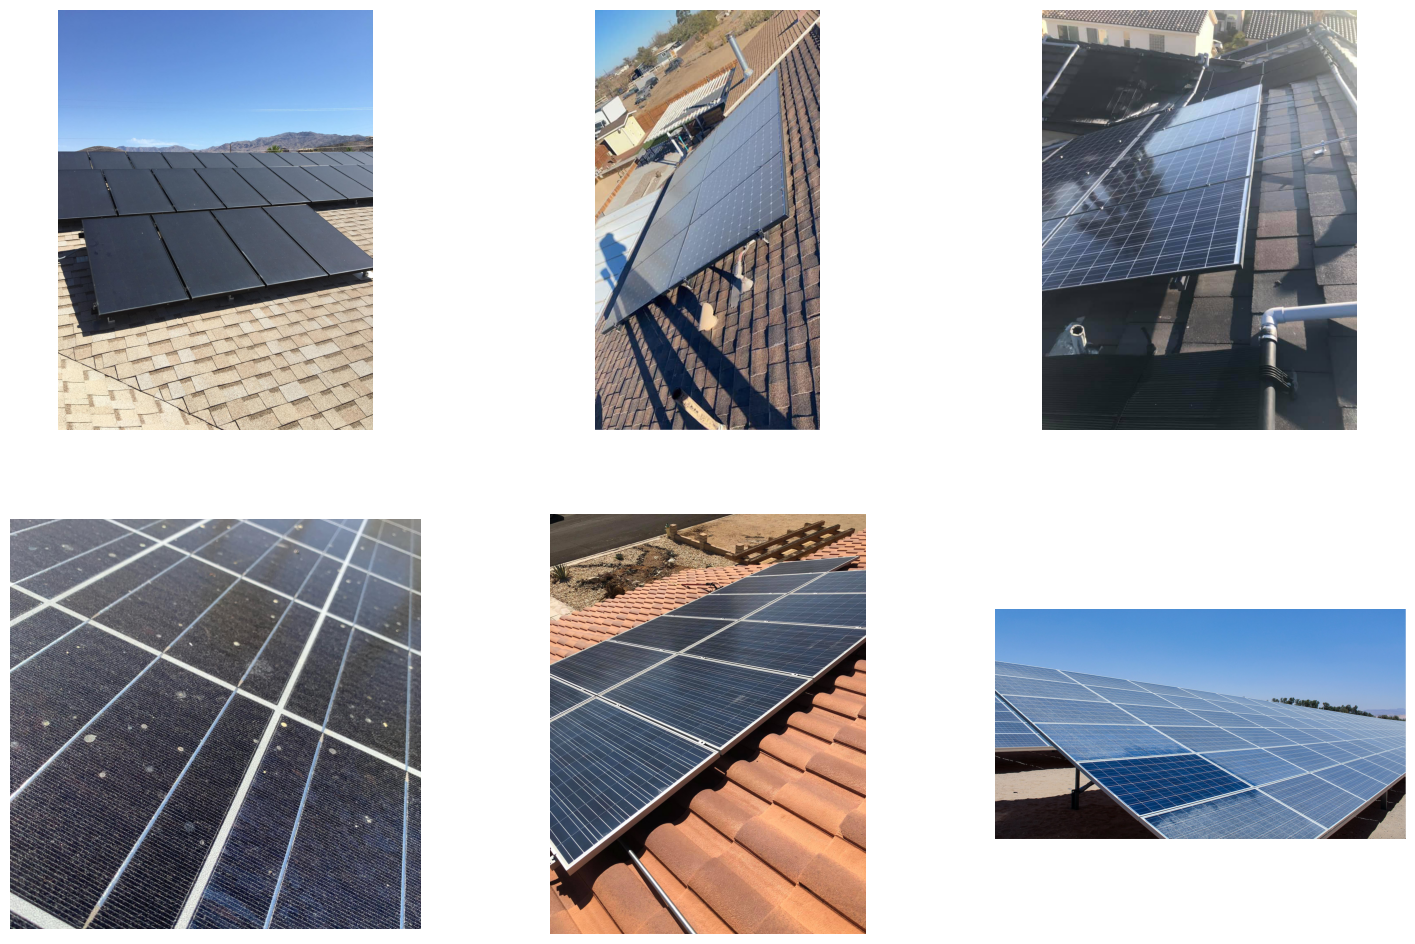

In [11]:
image_paths = os.listdir(dirty_images_dir)
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))

# randomly select 6 images to display as big images
big_image_paths = random.sample(image_paths, 6)

for i, image_path in enumerate(big_image_paths):
    image = os.path.join(dirty_images_dir, image_path)
    img = cv2.imread(image, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axs[i//3, i%3].imshow(img)
    axs[i//3, i%3].axis('off')

plt.show()

### Detecting Dust in Clean Solar Panels

In [12]:
"""# randomly select up to 6 clean images
clean_image_paths = random.sample(os.listdir(clean_images_dir), min(6, len(os.listdir(clean_images_dir))))

# create a grid of subplots
num_rows = (len(clean_image_paths) + 2) // 3
fig, axs = plt.subplots(nrows=num_rows, ncols=3, figsize=(18, 6*num_rows))

# call detect_dust() function on each clean image and display the results in subplots
for i, image_path in enumerate(clean_image_paths):
    image, result = detect_dust(os.path.join(clean_images_dir, image_path))
    axs[i//3, i%3].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axs[i//3, i%3].set_title("Original Image")
    axs[i//3, i%3].axis('off')
    axs[i//3+1, i%3].imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
    axs[i//3+1, i%3].set_title("Dust Particles Detected")
    axs[i//3+1, i%3].axis('off')

# hide any unused subplots
for i in range(len(clean_image_paths), num_rows*3):
    axs[i//3, i%3].axis('off')

# display the subplots
plt.show() """

'# randomly select up to 6 clean images\nclean_image_paths = random.sample(os.listdir(clean_images_dir), min(6, len(os.listdir(clean_images_dir))))\n\n# create a grid of subplots\nnum_rows = (len(clean_image_paths) + 2) // 3\nfig, axs = plt.subplots(nrows=num_rows, ncols=3, figsize=(18, 6*num_rows))\n\n# call detect_dust() function on each clean image and display the results in subplots\nfor i, image_path in enumerate(clean_image_paths):\n    image, result = detect_dust(os.path.join(clean_images_dir, image_path))\n    axs[i//3, i%3].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))\n    axs[i//3, i%3].set_title("Original Image")\n    axs[i//3, i%3].axis(\'off\')\n    axs[i//3+1, i%3].imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))\n    axs[i//3+1, i%3].set_title("Dust Particles Detected")\n    axs[i//3+1, i%3].axis(\'off\')\n\n# hide any unused subplots\nfor i in range(len(clean_image_paths), num_rows*3):\n    axs[i//3, i%3].axis(\'off\')\n\n# display the subplots\nplt.show() '

### Detecting Dust in Dusty Solar Panels

In [13]:
"""# randomly select 6 dusty images
dirty_image_paths = random.sample(os.listdir(dirty_images_dir), 6)

# create a 2x3 grid of subplots
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))

# call detect_dust() function on each clean image and display the results in subplots
for i, image_path in enumerate(dirty_image_paths):
    image, result = detect_dust(os.path.join(dirty_images_dir, image_path))
    axs[i//3, i%3].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axs[i//3, i%3].set_title("Original Image")
    axs[i//3, i%3].axis('off')
    axs[i//3+1, i%3].imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
    axs[i//3+1, i%3].set_title("Dust Particles Detected")
    axs[i//3+1, i%3].axis('off')

plt.show()"""

'# randomly select 6 dusty images\ndirty_image_paths = random.sample(os.listdir(dirty_images_dir), 6)\n\n# create a 2x3 grid of subplots\nfig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))\n\n# call detect_dust() function on each clean image and display the results in subplots\nfor i, image_path in enumerate(dirty_image_paths):\n    image, result = detect_dust(os.path.join(dirty_images_dir, image_path))\n    axs[i//3, i%3].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))\n    axs[i//3, i%3].set_title("Original Image")\n    axs[i//3, i%3].axis(\'off\')\n    axs[i//3+1, i%3].imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))\n    axs[i//3+1, i%3].set_title("Dust Particles Detected")\n    axs[i//3+1, i%3].axis(\'off\')\n\nplt.show()'

### Cropping of Clean Solar Panels Images

In [14]:
"""# randomly select up to 6 clean images
clean_image_paths = random.sample(os.listdir(clean_images_dir), min(6, len(os.listdir(clean_images_dir))))

# create a grid of subplots
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))

# call crop_solar_panel() function on each clean image and display the results in subplots
for i, image_path in enumerate(clean_image_paths):
    image = cv2.imread(os.path.join(clean_images_dir, image_path))
    cropped_image = crop_solar_panel(os.path.join(clean_images_dir, image_path))
    axs[i//3, i%3].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axs[i//3, i%3].set_title("Original Image")
    axs[i//3, i%3].axis('off')
    axs[i//3+1, i%3].imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))
    axs[i//3+1, i%3].set_title("Processed Image")
    axs[i//3+1, i%3].axis('off')

# hide any unused subplots
for i in range(len(clean_image_paths), 6):
    axs[i//3, i%3].axis('off')

# display the subplots
plt.show()"""

'# randomly select up to 6 clean images\nclean_image_paths = random.sample(os.listdir(clean_images_dir), min(6, len(os.listdir(clean_images_dir))))\n\n# create a grid of subplots\nfig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))\n\n# call crop_solar_panel() function on each clean image and display the results in subplots\nfor i, image_path in enumerate(clean_image_paths):\n    image = cv2.imread(os.path.join(clean_images_dir, image_path))\n    cropped_image = crop_solar_panel(os.path.join(clean_images_dir, image_path))\n    axs[i//3, i%3].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))\n    axs[i//3, i%3].set_title("Original Image")\n    axs[i//3, i%3].axis(\'off\')\n    axs[i//3+1, i%3].imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))\n    axs[i//3+1, i%3].set_title("Processed Image")\n    axs[i//3+1, i%3].axis(\'off\')\n\n# hide any unused subplots\nfor i in range(len(clean_image_paths), 6):\n    axs[i//3, i%3].axis(\'off\')\n\n# display the subplots\nplt.show()'

### 2.4 Splitting the Data

In [15]:
dusty_labels = np.ones(len(dusty_images_array))
clean_labels = np.zeros(len(clean_images_array))

In [16]:
X = np.concatenate((clean_images_array, dusty_images_array))
y = np.concatenate((clean_labels, dusty_labels))

In [17]:
print("The shape of the input data: {}".format(X.shape))
print("The shape of the output data: {}".format(y.shape))

The shape of the input data: (7303, 224, 224, 3)
The shape of the output data: (7303,)


In [18]:
# Dividing the data into training, cross-validation and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, 
                                                   random_state = RANDOM_STATE,
                                                   stratify = y, shuffle = True)

X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size = 0.2,
                                                  random_state = RANDOM_STATE,
                                                  stratify = y_train, shuffle = True)

In [19]:
print("The shape of the input train data: {}".format(X_train.shape))
print("The shape of the input cross-validation data: {}".format(X_cv.shape))
print("The shape of the input test data: {}".format(X_test.shape))
print("----------------------------------------------------")
print("The shape of the output train data: {}".format(y_train.shape))
print("The shape of the output cross-validation data: {}".format(y_cv.shape))
print("The shape of the output test data: {}".format(y_test.shape))

The shape of the input train data: (4673, 224, 224, 3)
The shape of the input cross-validation data: (1169, 224, 224, 3)
The shape of the input test data: (1461, 224, 224, 3)
----------------------------------------------------
The shape of the output train data: (4673,)
The shape of the output cross-validation data: (1169,)
The shape of the output test data: (1461,)


### 2.5 Feature Engineering

#### 2.5.1 Normalization

In [20]:
# Performing normalization as part of feature engineering
X_train = X_train / 255
X_cv = X_cv / 255
X_test = X_test / 255

### 2.6 Convolutional Neural Networks (CNNs)

#### 2.6.1 Training CNN Model (Configuration 1)

In [21]:
model = Sequential()
model.add(Conv2D(8, (2, 2), activation = 'relu', input_shape = INPUT_SHAPE))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Conv2D(4, (2, 2), activation = 'relu'))
model.add(Flatten())
model.add(Dense(1, activation = 'sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer = 'Adam',
             metrics = ['accuracy'])

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 223, 223, 8)       104       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 8)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 110, 110, 4)       132       
_________________________________________________________________
flatten (Flatten)            (None, 48400)             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 48401     
Total params: 48,637
Trainable params: 48,637
Non-trainable params: 0
_________________________________________________________________


In [23]:
model.fit(X_train, y_train, validation_data = (X_cv, y_cv), epochs = 10,
         batch_size = BATCH_SIZE)

Epoch 1/10
74/74 [==============================] - 12s 168ms/step - loss: 0.5966 - accuracy: 0.6696 - val_loss: 0.5520 - val_accuracy: 0.7288
Epoch 2/10
74/74 [==============================] - 2s 30ms/step - loss: 0.4611 - accuracy: 0.7993 - val_loss: 0.5569 - val_accuracy: 0.7408
Epoch 3/10
74/74 [==============================] - 2s 27ms/step - loss: 0.3919 - accuracy: 0.8380 - val_loss: 0.4977 - val_accuracy: 0.7656
Epoch 4/10
74/74 [==============================] - 2s 27ms/step - loss: 0.3104 - accuracy: 0.8868 - val_loss: 0.4973 - val_accuracy: 0.7648
Epoch 5/10
74/74 [==============================] - 2s 26ms/step - loss: 0.2657 - accuracy: 0.9071 - val_loss: 0.5057 - val_accuracy: 0.7656
Epoch 6/10
74/74 [==============================] - 2s 26ms/step - loss: 0.2097 - accuracy: 0.9349 - val_loss: 0.5268 - val_accuracy: 0.7485
Epoch 7/10
74/74 [==============================] - 2s 26ms/step - loss: 0.1694 - accuracy: 0.9568 - val_loss: 0.5449 - val_accuracy: 0.7494
Epoch 8/10


In [24]:
training_loss = model.history.history['loss']
cross_validation_loss = model.history.history['val_loss']
training_accuracy = model.history.history['accuracy']
cross_validation_accuracy = model.history.history['val_accuracy']
y_predictions_raw = model.predict(X_test)
y_predictions = zero_one_classifier(y_predictions_raw)

AUC for our classifier is: 0.6449909562985006


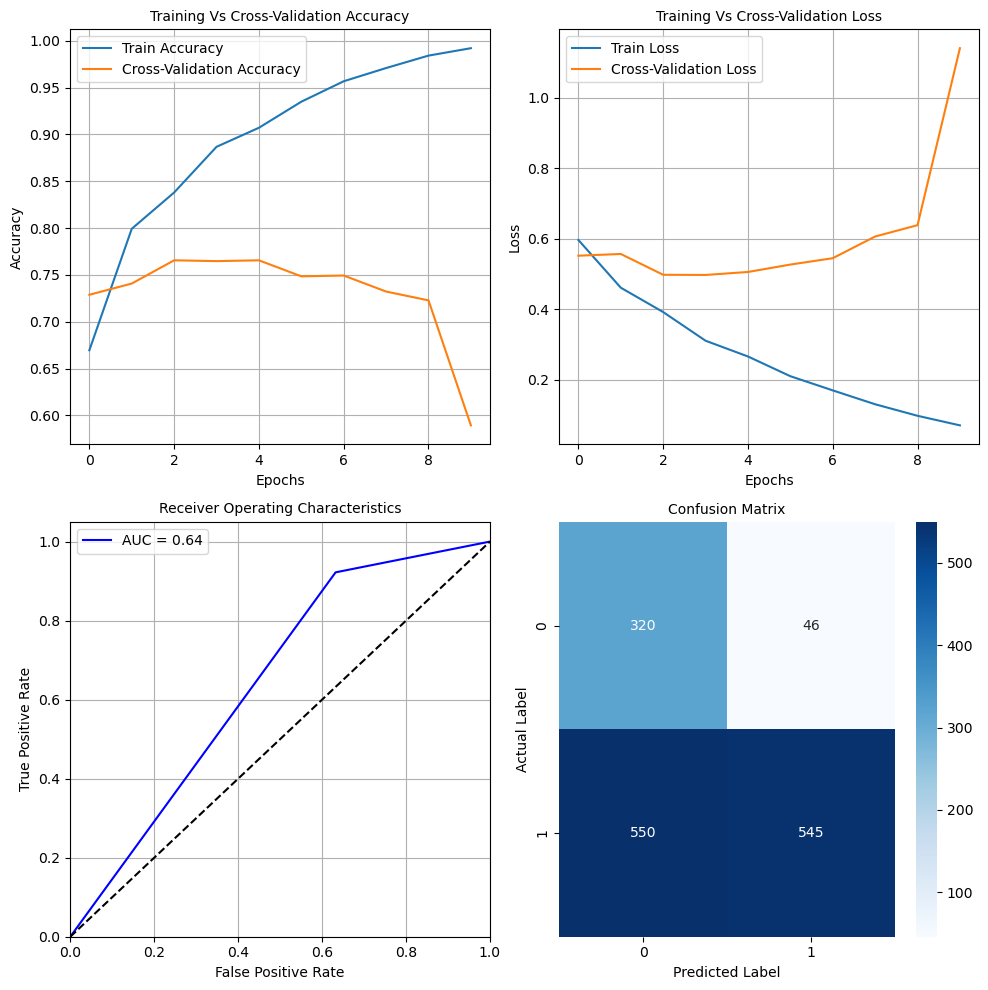

---------------------Classification Report---------------------
              precision    recall  f1-score   support

           0       0.37      0.87      0.52       366
           1       0.92      0.50      0.65      1095

    accuracy                           0.59      1461
   macro avg       0.64      0.69      0.58      1461
weighted avg       0.78      0.59      0.61      1461



In [25]:
metrics_tracker(training_accuracy, cross_validation_accuracy,
                   training_loss, cross_validation_loss, y_test, y_predictions)

#### 2.6.2 Training CNN Model (Configuration 2)

In [26]:
model = Sequential()
model.add(Conv2D(4, (2, 2), activation = 'relu', input_shape = INPUT_SHAPE))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Conv2D(2, (2, 2), activation = 'relu'))
model.add(Flatten())
model.add(Dense(1, activation = 'sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer = 'Adam',
             metrics = ['accuracy'])

In [27]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 223, 223, 4)       52        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 111, 111, 4)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 110, 110, 2)       34        
_________________________________________________________________
flatten_1 (Flatten)          (None, 24200)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 24201     
Total params: 24,287
Trainable params: 24,287
Non-trainable params: 0
_________________________________________________________________


In [28]:
model.fit(X_train, y_train, validation_data = (X_cv, y_cv), epochs = 20,
         batch_size = BATCH_SIZE)

Epoch 1/20
74/74 [==============================] - 12s 157ms/step - loss: 0.6360 - accuracy: 0.6026 - val_loss: 0.6032 - val_accuracy: 0.6356
Epoch 2/20
74/74 [==============================] - 2s 27ms/step - loss: 0.5492 - accuracy: 0.6983 - val_loss: 0.5855 - val_accuracy: 0.6972
Epoch 3/20
74/74 [==============================] - 2s 25ms/step - loss: 0.4949 - accuracy: 0.7766 - val_loss: 0.5789 - val_accuracy: 0.7015
Epoch 4/20
74/74 [==============================] - 2s 28ms/step - loss: 0.4255 - accuracy: 0.8217 - val_loss: 0.5972 - val_accuracy: 0.7032
Epoch 5/20
74/74 [==============================] - 2s 26ms/step - loss: 0.3877 - accuracy: 0.8369 - val_loss: 0.5684 - val_accuracy: 0.7134
Epoch 6/20
74/74 [==============================] - 2s 25ms/step - loss: 0.3266 - accuracy: 0.8921 - val_loss: 0.5763 - val_accuracy: 0.7228
Epoch 7/20
74/74 [==============================] - 2s 25ms/step - loss: 0.2731 - accuracy: 0.9170 - val_loss: 0.6044 - val_accuracy: 0.7117
Epoch 8/20


In [29]:
training_loss = model.history.history['loss']
cross_validation_loss = model.history.history['val_loss']
training_accuracy = model.history.history['accuracy']
cross_validation_accuracy = model.history.history['val_accuracy']
y_predictions_raw = model.predict(X_test)
y_predictions = zero_one_classifier(y_predictions_raw)

AUC for our classifier is: 0.6682711943520625


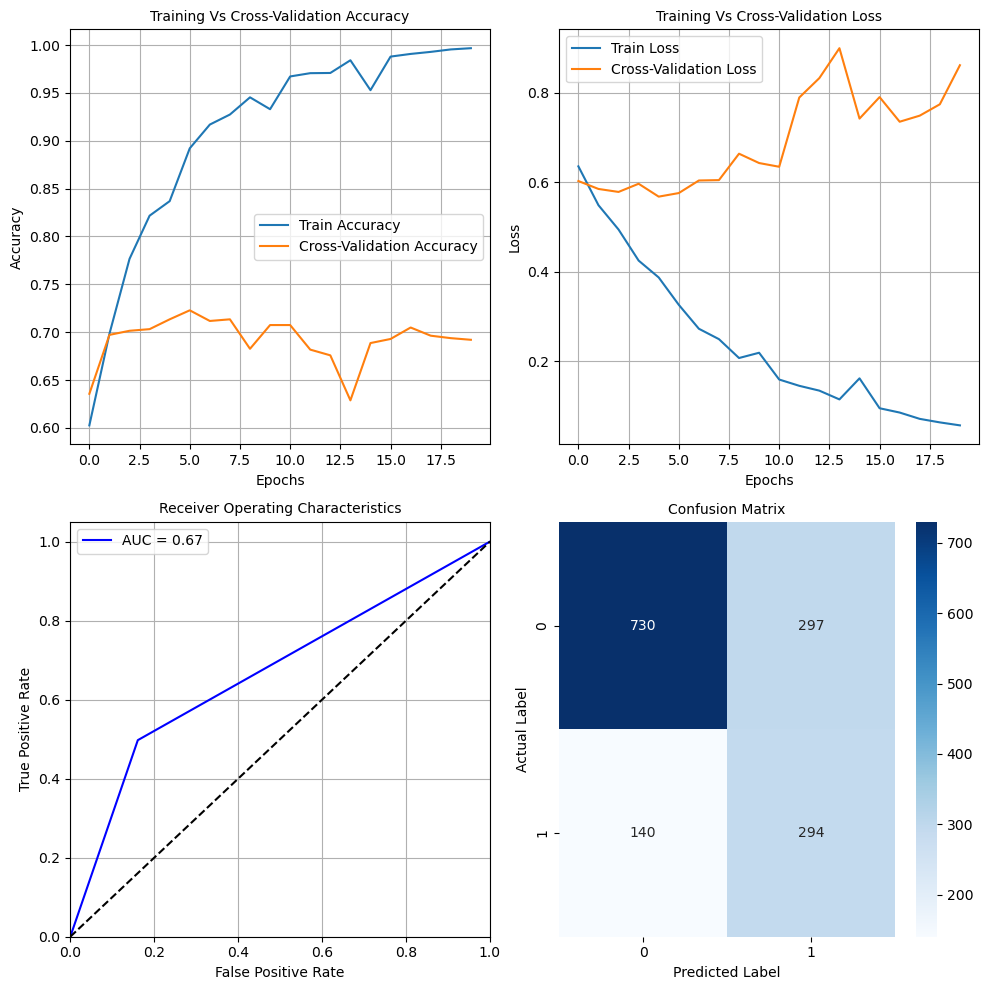

---------------------Classification Report---------------------
              precision    recall  f1-score   support

           0       0.84      0.71      0.77      1027
           1       0.50      0.68      0.57       434

    accuracy                           0.70      1461
   macro avg       0.67      0.69      0.67      1461
weighted avg       0.74      0.70      0.71      1461



In [30]:
metrics_tracker(training_accuracy, cross_validation_accuracy,
                   training_loss, cross_validation_loss, y_test, y_predictions)

#### 2.6.3 Training CNN Model (Configuration 3)

In [31]:
model = Sequential()
model.add(Conv2D(2, (3, 3), activation = 'relu', input_shape = INPUT_SHAPE))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.6))
model.add(Conv2D(2, (2, 2), activation = 'relu'))
model.add(Flatten())
model.add(Dropout(0.6))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer = 'Adam',
             metrics = ['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 222, 222, 2)       56        
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 111, 111, 2)       0         
_________________________________________________________________
dropout (Dropout)            (None, 111, 111, 2)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 110, 110, 2)       18        
_________________________________________________________________
flatten_2 (Flatten)          (None, 24200)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 24200)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                

In [32]:
model.fit(X_train, y_train, validation_data = (X_cv, y_cv), epochs = 20,
         batch_size = BATCH_SIZE)

Epoch 1/20
74/74 [==============================] - 7s 91ms/step - loss: 0.6492 - accuracy: 0.6169 - val_loss: 0.6386 - val_accuracy: 0.6399
Epoch 2/20
74/74 [==============================] - 2s 24ms/step - loss: 0.5982 - accuracy: 0.6824 - val_loss: 0.6144 - val_accuracy: 0.6826
Epoch 3/20
74/74 [==============================] - 2s 24ms/step - loss: 0.5634 - accuracy: 0.7289 - val_loss: 0.6024 - val_accuracy: 0.7109
Epoch 4/20
74/74 [==============================] - 2s 25ms/step - loss: 0.5462 - accuracy: 0.7359 - val_loss: 0.5964 - val_accuracy: 0.7032
Epoch 5/20
74/74 [==============================] - 2s 24ms/step - loss: 0.5503 - accuracy: 0.7316 - val_loss: 0.5977 - val_accuracy: 0.7074
Epoch 6/20
74/74 [==============================] - 2s 24ms/step - loss: 0.5325 - accuracy: 0.7460 - val_loss: 0.5921 - val_accuracy: 0.7023
Epoch 7/20
74/74 [==============================] - 2s 24ms/step - loss: 0.5320 - accuracy: 0.7404 - val_loss: 0.5875 - val_accuracy: 0.7117
Epoch 8/20
74

In [33]:
training_loss = model.history.history['loss']
cross_validation_loss = model.history.history['val_loss']
training_accuracy = model.history.history['accuracy']
cross_validation_accuracy = model.history.history['val_accuracy']
y_predictions_raw = model.predict(X_test)
y_predictions = zero_one_classifier(y_predictions_raw)

AUC for our classifier is: 0.7157302059630084


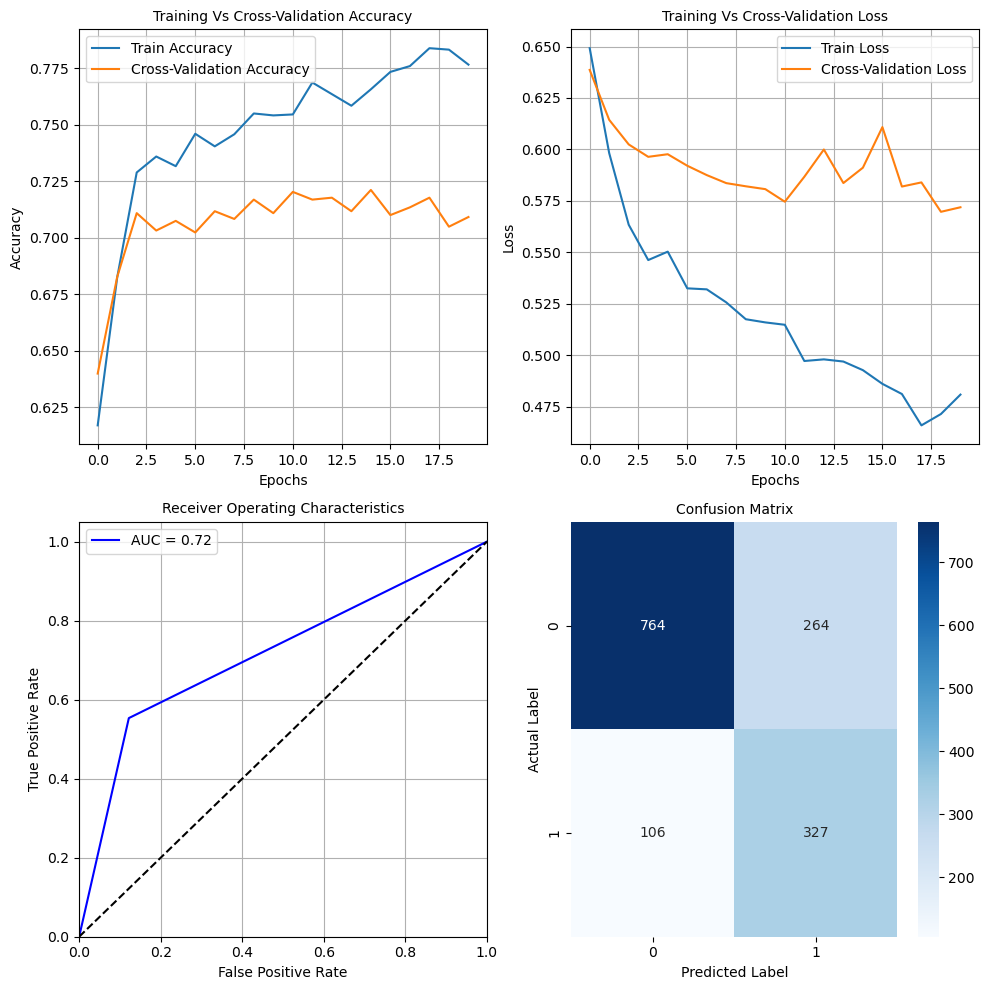

---------------------Classification Report---------------------
              precision    recall  f1-score   support

           0       0.88      0.74      0.81      1028
           1       0.55      0.76      0.64       433

    accuracy                           0.75      1461
   macro avg       0.72      0.75      0.72      1461
weighted avg       0.78      0.75      0.76      1461



In [34]:
metrics_tracker(training_accuracy, cross_validation_accuracy,
                   training_loss, cross_validation_loss, y_test, y_predictions)

#### 2.6.4 Training CNN Model (Configuration 4)

In [35]:
model = Sequential()
model.add(Conv2D(2, (2, 2), activation = 'relu', input_shape = INPUT_SHAPE))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Flatten())
model.add(Dense(1, activation = 'sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer = 'Adam',
             metrics = ['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 223, 223, 2)       26        
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 111, 111, 2)       0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 24642)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 24643     
Total params: 24,669
Trainable params: 24,669
Non-trainable params: 0
_________________________________________________________________


In [36]:
model.fit(X_train, y_train, validation_data = (X_cv, y_cv), epochs = 20,
         batch_size = BATCH_SIZE)

Epoch 1/20
74/74 [==============================] - 5s 72ms/step - loss: 1.2767 - accuracy: 0.5412 - val_loss: 0.6408 - val_accuracy: 0.6287
Epoch 2/20
74/74 [==============================] - 3s 35ms/step - loss: 0.6407 - accuracy: 0.6313 - val_loss: 1.0536 - val_accuracy: 0.4517
Epoch 3/20
74/74 [==============================] - 2s 30ms/step - loss: 0.6873 - accuracy: 0.6202 - val_loss: 0.8391 - val_accuracy: 0.5945
Epoch 4/20
74/74 [==============================] - 2s 27ms/step - loss: 0.5947 - accuracy: 0.6790 - val_loss: 0.8975 - val_accuracy: 0.5979
Epoch 5/20
74/74 [==============================] - 2s 27ms/step - loss: 0.5603 - accuracy: 0.7049 - val_loss: 1.0711 - val_accuracy: 0.5988
Epoch 6/20
74/74 [==============================] - 2s 26ms/step - loss: 0.5658 - accuracy: 0.7058 - val_loss: 0.6384 - val_accuracy: 0.6347
Epoch 7/20
74/74 [==============================] - 2s 26ms/step - loss: 0.4685 - accuracy: 0.7993 - val_loss: 0.7015 - val_accuracy: 0.5851
Epoch 8/20
74

In [37]:
training_loss = model.history.history['loss']
cross_validation_loss = model.history.history['val_loss']
training_accuracy = model.history.history['accuracy']
cross_validation_accuracy = model.history.history['val_accuracy']
y_predictions_raw = model.predict(X_test)
y_predictions = zero_one_classifier(y_predictions_raw)

AUC for our classifier is: 0.6342668767139273


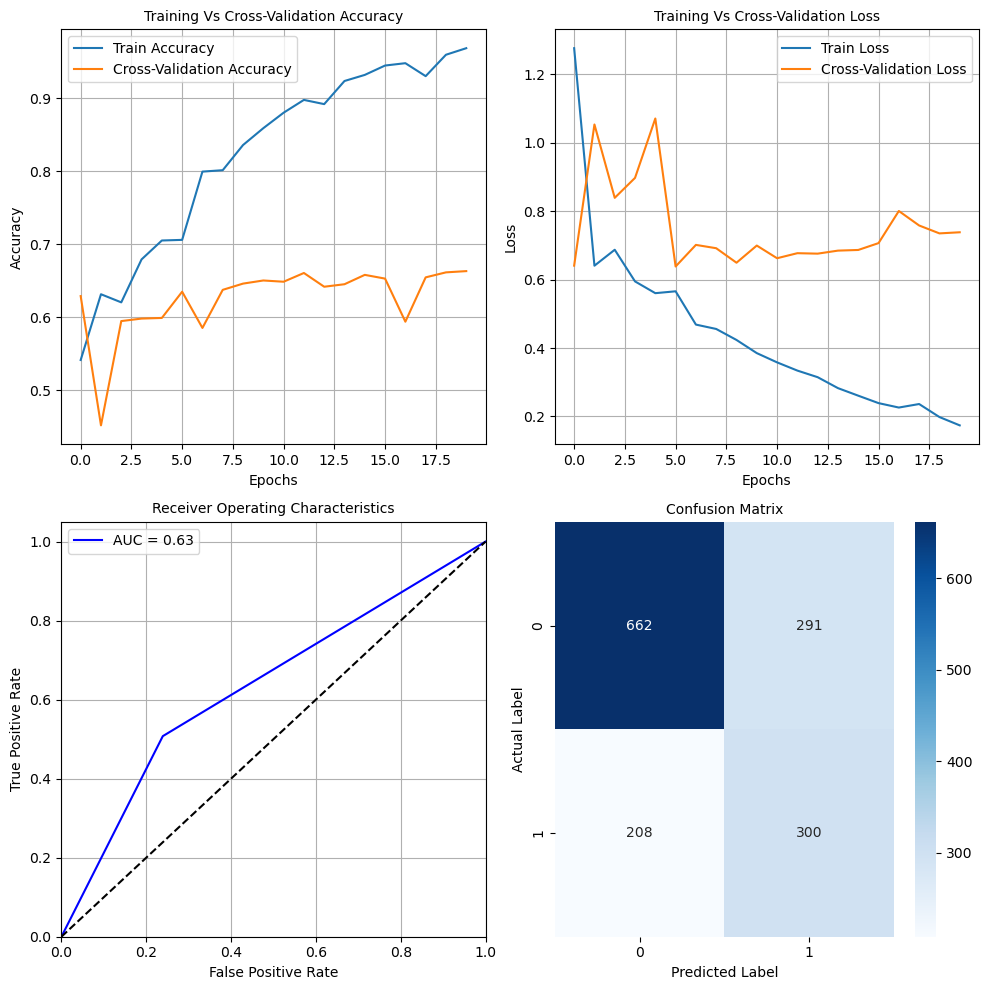

---------------------Classification Report---------------------
              precision    recall  f1-score   support

           0       0.76      0.69      0.73       953
           1       0.51      0.59      0.55       508

    accuracy                           0.66      1461
   macro avg       0.63      0.64      0.64      1461
weighted avg       0.67      0.66      0.66      1461



In [38]:
metrics_tracker(training_accuracy, cross_validation_accuracy,
                   training_loss, cross_validation_loss, y_test, y_predictions)

### 2.7 Transfer Learning

#### 2.7.1 VGG16 Network

In [39]:
# Loading the VGG16 Model and using transfer learning for our task
headmodel = VGG16(weights = "imagenet", include_top = False,
                 input_shape = INPUT_SHAPE)
model = headmodel.output
model = AveragePooling2D(pool_size = (2, 2))(model)
model = Flatten(name = 'flatten')(model)
model = Dense(64, activation = 'relu')(model)
model = Dropout(0.3)(model)
model = Dense(32, activation = 'relu')(model)
model = Dropout(0.1)(model)
model = Dense(1, activation = 'sigmoid')(model)

final_model = Model(inputs = headmodel.input, outputs = model)

for layer in headmodel.layers[: -2]:
    layer.trainable = False

In [40]:
opt = Adam(lr = 1e-2)
final_model.compile(loss = "binary_crossentropy", optimizer = opt,
                   metrics = ["accuracy"])

In [41]:
final_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [42]:
fitted_model = final_model.fit(X_train, y_train, epochs = 10, 
                              validation_data = (X_cv, y_cv),
                              batch_size = BATCH_SIZE)

Epoch 1/10
74/74 [==============================] - 21s 289ms/step - loss: 1.9726 - accuracy: 0.5791 - val_loss: 0.6368 - val_accuracy: 0.6407
Epoch 2/10
74/74 [==============================] - 15s 200ms/step - loss: 0.6137 - accuracy: 0.6465 - val_loss: 0.7851 - val_accuracy: 0.5680
Epoch 3/10
74/74 [==============================] - 18s 240ms/step - loss: 0.5480 - accuracy: 0.7130 - val_loss: 0.5119 - val_accuracy: 0.7322
Epoch 4/10
74/74 [==============================] - 21s 287ms/step - loss: 0.4843 - accuracy: 0.7608 - val_loss: 0.6411 - val_accuracy: 0.6980
Epoch 5/10
74/74 [==============================] - 25s 342ms/step - loss: 0.4948 - accuracy: 0.7652 - val_loss: 0.5183 - val_accuracy: 0.7553
Epoch 6/10
74/74 [==============================] - 29s 388ms/step - loss: 0.4651 - accuracy: 0.7736 - val_loss: 0.5285 - val_accuracy: 0.7588
Epoch 7/10
74/74 [==============================] - 31s 416ms/step - loss: 0.4320 - accuracy: 0.8021 - val_loss: 0.5007 - val_accuracy: 0.7399

In [43]:
training_loss = fitted_model.history['loss']
cross_validation_loss = fitted_model.history['val_loss']
training_accuracy = fitted_model.history['accuracy']
cross_validation_accuracy = fitted_model.history['val_accuracy']
y_predictions_raw = final_model.predict(X_test)
y_predictions = zero_one_classifier(y_predictions_raw)

AUC for our classifier is: 0.7729564151934185


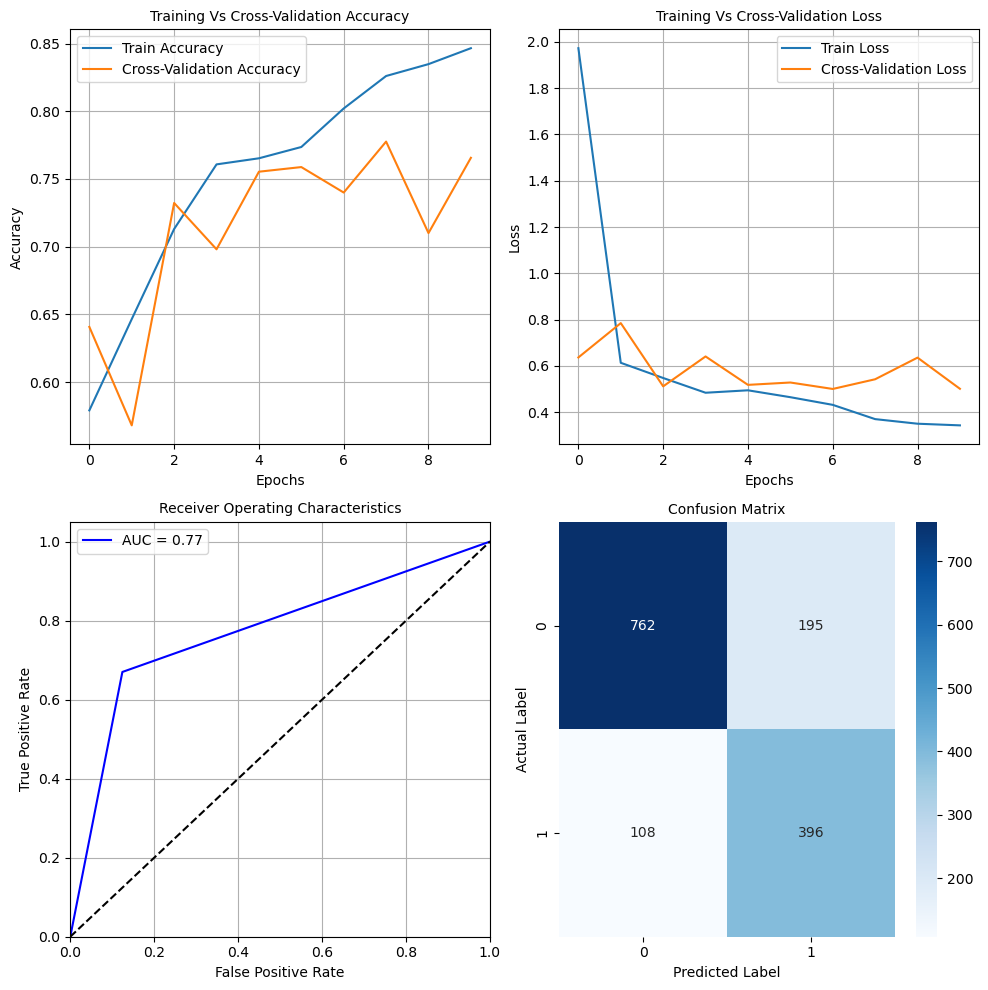

---------------------Classification Report---------------------
              precision    recall  f1-score   support

           0       0.88      0.80      0.83       957
           1       0.67      0.79      0.72       504

    accuracy                           0.79      1461
   macro avg       0.77      0.79      0.78      1461
weighted avg       0.80      0.79      0.80      1461



In [44]:
metrics_tracker(training_accuracy, cross_validation_accuracy,
                   training_loss, cross_validation_loss, y_test, y_predictions)

#### 2.7.2 VGG19 Network

In [45]:
# Loading the VGG19 Model and using transfer learning for our task
headmodel = VGG19(weights = "imagenet", include_top = False,
                 input_shape = (224, 224, 3))
model = headmodel.output
model = AveragePooling2D(pool_size = (2, 2))(model)
model = Flatten(name = 'flatten')(model)
model = Dense(64, activation = 'relu')(model)
model = Dropout(0.3)(model)
model = Dense(32, activation = 'relu')(model)
model = Dropout(0.1)(model)
model = Dense(1, activation = 'sigmoid')(model)

final_model = Model(inputs = headmodel.input, outputs = model)

for layer in headmodel.layers[: -2]:
    layer.trainable = False

In [46]:
opt = Adam(lr = 1e-2)
final_model.compile(loss = "binary_crossentropy", optimizer = opt,
                   metrics = ["accuracy"])

In [47]:
final_model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [48]:
fitted_model = final_model.fit(X_train, y_train, epochs = 10, 
                              validation_data = (X_cv, y_cv),
                              batch_size = BATCH_SIZE)

Epoch 1/10
74/74 [==============================] - 27s 363ms/step - loss: 1.4439 - accuracy: 0.5964 - val_loss: 0.6026 - val_accuracy: 0.6116
Epoch 2/10
74/74 [==============================] - 26s 347ms/step - loss: 0.5776 - accuracy: 0.6758 - val_loss: 0.5696 - val_accuracy: 0.7066
Epoch 3/10
74/74 [==============================] - 38s 508ms/step - loss: 0.5200 - accuracy: 0.7291 - val_loss: 0.5850 - val_accuracy: 0.6630
Epoch 4/10
74/74 [==============================] - 46s 617ms/step - loss: 0.5032 - accuracy: 0.7556 - val_loss: 0.5545 - val_accuracy: 0.7280
Epoch 5/10
74/74 [==============================] - 50s 678ms/step - loss: 0.4687 - accuracy: 0.7854 - val_loss: 0.6588 - val_accuracy: 0.6707
Epoch 6/10
74/74 [==============================] - 52s 696ms/step - loss: 0.5535 - accuracy: 0.7282 - val_loss: 0.5266 - val_accuracy: 0.7322
Epoch 7/10
74/74 [==============================] - 51s 693ms/step - loss: 0.4491 - accuracy: 0.7901 - val_loss: 0.5066 - val_accuracy: 0.7571

In [49]:
training_loss = fitted_model.history['loss']
cross_validation_loss = fitted_model.history['val_loss']
training_accuracy = fitted_model.history['accuracy']
cross_validation_accuracy = fitted_model.history['val_accuracy']
y_predictions_raw = final_model.predict(X_test)
y_predictions = zero_one_classifier(y_predictions_raw)

AUC for our classifier is: 0.7720578796895968


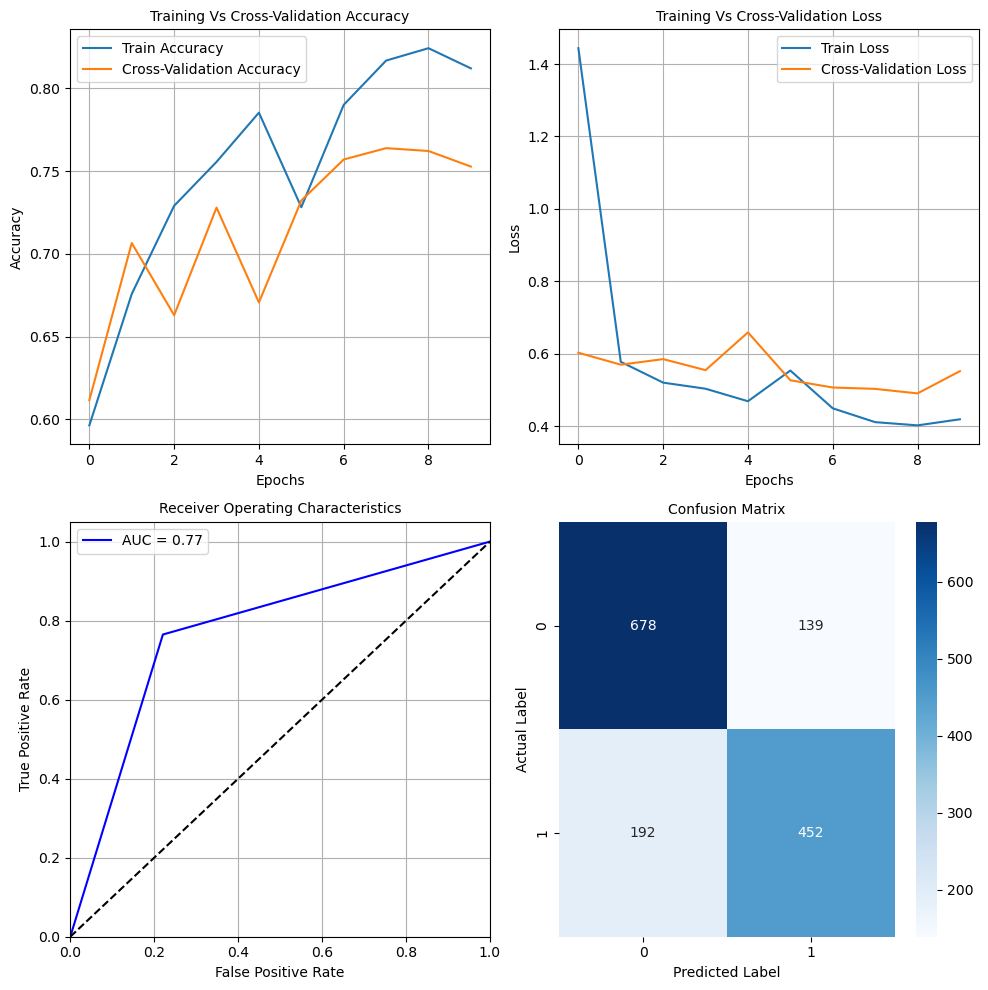

---------------------Classification Report---------------------
              precision    recall  f1-score   support

           0       0.78      0.83      0.80       817
           1       0.76      0.70      0.73       644

    accuracy                           0.77      1461
   macro avg       0.77      0.77      0.77      1461
weighted avg       0.77      0.77      0.77      1461



In [50]:
metrics_tracker(training_accuracy, cross_validation_accuracy,
                   training_loss, cross_validation_loss, y_test, y_predictions)

#### 2.7.3 InceptionNet 

In [51]:
# Loading the InceptionNet Model and using transfer learning for our task
headmodel = InceptionV3(weights = "imagenet", include_top = False,
                 input_shape = (224, 224, 3))
model = headmodel.output
model = AveragePooling2D(pool_size = (2, 2))(model)
model = Flatten(name = 'flatten')(model)
model = Dense(64, activation = 'relu')(model)
model = Dropout(0.3)(model)
model = Dense(32, activation = 'relu')(model)
model = Dropout(0.1)(model)
model = Dense(1, activation = 'sigmoid')(model)

final_model = Model(inputs = headmodel.input, outputs = model)

for layer in headmodel.layers[: -2]:
    layer.trainable = False
    
opt = Adam(lr = 1e-2)
final_model.compile(loss = "binary_crossentropy", optimizer = opt,
                   metrics = ["accuracy"])

final_model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 111, 111, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d_7[0][0]                   
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [52]:
fitted_model = final_model.fit(X_train, y_train, epochs = 10, 
                              validation_data = (X_cv, y_cv),
                              batch_size = BATCH_SIZE)

Epoch 1/10
74/74 [==============================] - 18s 248ms/step - loss: 1.8652 - accuracy: 0.5487 - val_loss: 0.6347 - val_accuracy: 0.5962
Epoch 2/10
74/74 [==============================] - 8s 115ms/step - loss: 0.6389 - accuracy: 0.5898 - val_loss: 1.1097 - val_accuracy: 0.5962
Epoch 3/10
74/74 [==============================] - 10s 140ms/step - loss: 0.6835 - accuracy: 0.5878 - val_loss: 0.6345 - val_accuracy: 0.5979
Epoch 4/10
74/74 [==============================] - 13s 174ms/step - loss: 0.6183 - accuracy: 0.6015 - val_loss: 0.5893 - val_accuracy: 0.7280
Epoch 5/10
74/74 [==============================] - 15s 198ms/step - loss: 0.6046 - accuracy: 0.6315 - val_loss: 0.5477 - val_accuracy: 0.7553
Epoch 6/10
74/74 [==============================] - 17s 226ms/step - loss: 0.6191 - accuracy: 0.5848 - val_loss: 0.5762 - val_accuracy: 0.7211
Epoch 7/10
74/74 [==============================] - 17s 236ms/step - loss: 0.5521 - accuracy: 0.6886 - val_loss: 0.6262 - val_accuracy: 0.6287


In [53]:
training_loss = fitted_model.history['loss']
cross_validation_loss = fitted_model.history['val_loss']
training_accuracy = fitted_model.history['accuracy']
cross_validation_accuracy = fitted_model.history['val_accuracy']
y_predictions_raw = final_model.predict(X_test)
y_predictions = zero_one_classifier(y_predictions_raw)

AUC for our classifier is: 0.7650942295349787


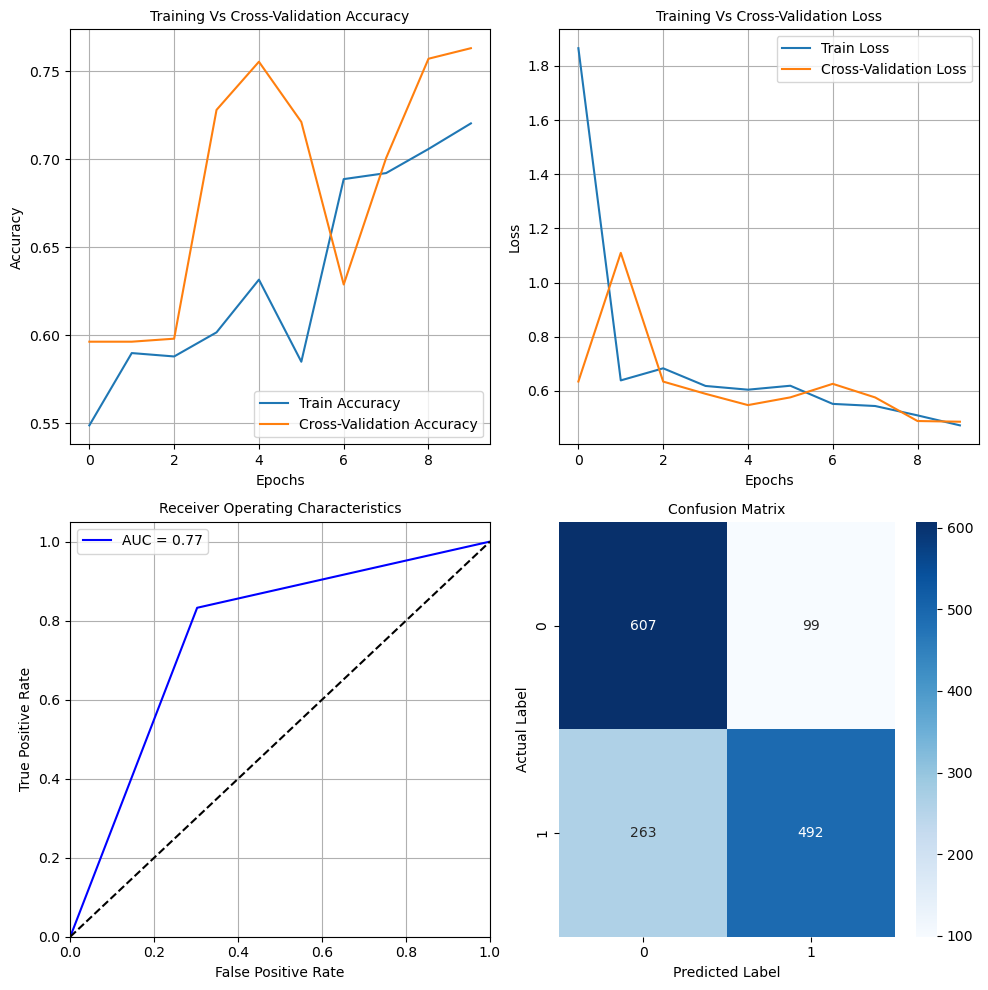

---------------------Classification Report---------------------
              precision    recall  f1-score   support

           0       0.70      0.86      0.77       706
           1       0.83      0.65      0.73       755

    accuracy                           0.75      1461
   macro avg       0.77      0.76      0.75      1461
weighted avg       0.77      0.75      0.75      1461



In [54]:
metrics_tracker(training_accuracy, cross_validation_accuracy,
                   training_loss, cross_validation_loss, y_test, y_predictions)

#### 2.7.4 MobileNet

In [55]:
# Loading the MobileNet Model and using transfer learning for our task
headmodel = MobileNet(weights = "imagenet", include_top = False,
                 input_shape = (224, 224, 3))
model = headmodel.output
model = AveragePooling2D(pool_size = (2, 2))(model)
model = Flatten(name = 'flatten')(model)
model = Dense(64, activation = 'relu')(model)
model = Dropout(0.3)(model)
model = Dense(32, activation = 'relu')(model)
model = Dropout(0.1)(model)
model = Dense(1, activation = 'sigmoid')(model)

final_model = Model(inputs = headmodel.input, outputs = model)

for layer in headmodel.layers[: -2]:
    layer.trainable = False
    
opt = Adam(lr = 1e-2)
final_model.compile(loss = "binary_crossentropy", optimizer = opt,
                   metrics = ["accuracy"])

final_model.summary()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)     

In [56]:
fitted_model = final_model.fit(X_train, y_train, epochs = 10, 
                              validation_data = (X_cv, y_cv),
                              batch_size = BATCH_SIZE)

Epoch 1/10
74/74 [==============================] - 11s 145ms/step - loss: 2.7512 - accuracy: 0.6118 - val_loss: 0.6274 - val_accuracy: 0.7417
Epoch 2/10
74/74 [==============================] - 5s 66ms/step - loss: 0.5607 - accuracy: 0.7152 - val_loss: 0.5053 - val_accuracy: 0.7511
Epoch 3/10
74/74 [==============================] - 5s 68ms/step - loss: 0.5055 - accuracy: 0.6961 - val_loss: 0.4151 - val_accuracy: 0.8135
Epoch 4/10
74/74 [==============================] - 5s 72ms/step - loss: 0.4557 - accuracy: 0.7501 - val_loss: 0.4326 - val_accuracy: 0.8255
Epoch 5/10
74/74 [==============================] - 6s 79ms/step - loss: 0.3832 - accuracy: 0.8053 - val_loss: 0.4274 - val_accuracy: 0.8033
Epoch 6/10
74/74 [==============================] - 6s 79ms/step - loss: 0.3476 - accuracy: 0.8235 - val_loss: 0.5677 - val_accuracy: 0.7870
Epoch 7/10
74/74 [==============================] - 6s 86ms/step - loss: 0.3178 - accuracy: 0.8416 - val_loss: 0.3560 - val_accuracy: 0.8383
Epoch 8/10


In [57]:
training_loss = fitted_model.history['loss']
cross_validation_loss = fitted_model.history['val_loss']
training_accuracy = fitted_model.history['accuracy']
cross_validation_accuracy = fitted_model.history['val_accuracy']
y_predictions_raw = final_model.predict(X_test)
y_predictions = zero_one_classifier(y_predictions_raw)

AUC for our classifier is: 0.8126903553299493


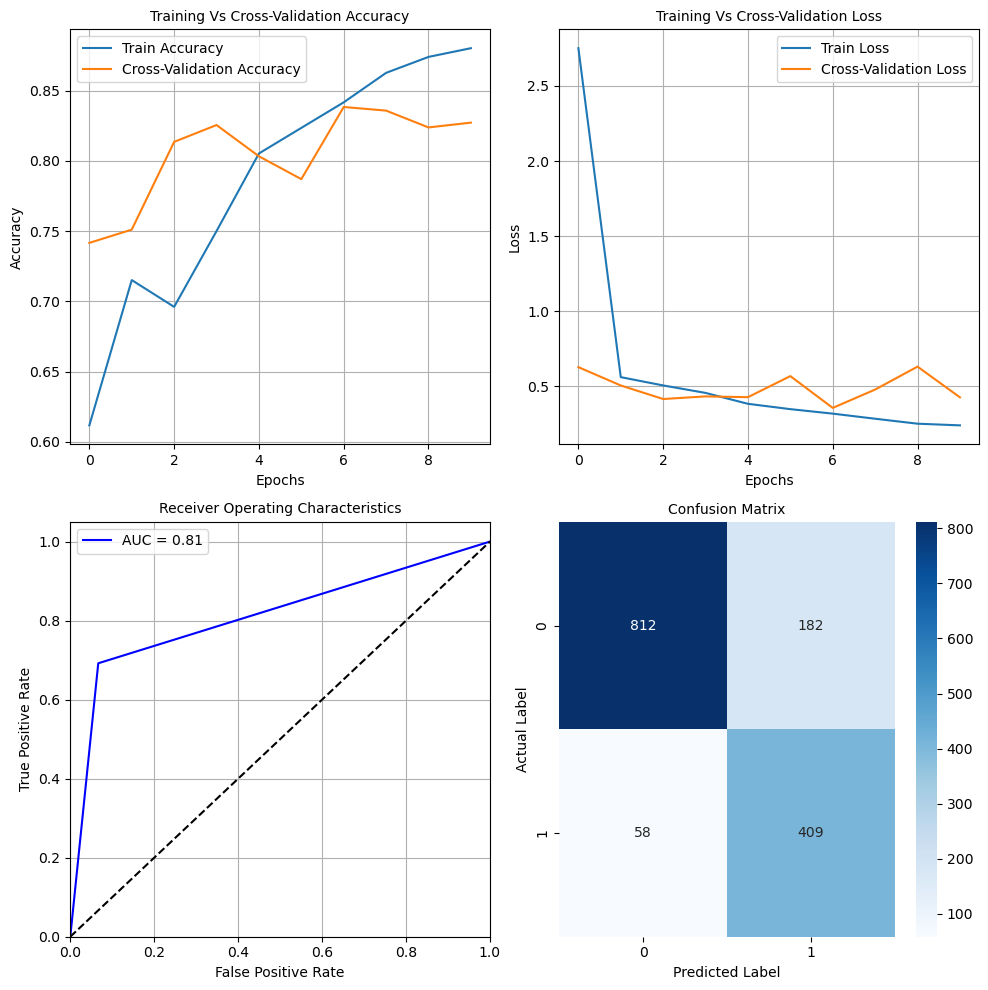

---------------------Classification Report---------------------
              precision    recall  f1-score   support

           0       0.93      0.82      0.87       994
           1       0.69      0.88      0.77       467

    accuracy                           0.84      1461
   macro avg       0.81      0.85      0.82      1461
weighted avg       0.86      0.84      0.84      1461



In [58]:
metrics_tracker(training_accuracy, cross_validation_accuracy,
                   training_loss, cross_validation_loss, y_test, y_predictions)

#### 2.7.5 Xception Network

In [59]:
# Loading the Xception Model and using transfer learning for our task
headmodel = Xception(weights = "imagenet", include_top = False,
                 input_shape = (224, 224, 3))
model = headmodel.output
model = AveragePooling2D(pool_size = (2, 2))(model)
model = Flatten(name = 'flatten')(model)
model = Dense(64, activation = 'relu')(model)
model = Dropout(0.3)(model)
model = Dense(32, activation = 'relu')(model)
model = Dropout(0.1)(model)
model = Dense(1, activation = 'sigmoid')(model)

final_model = Model(inputs = headmodel.input, outputs = model)

for layer in headmodel.layers[: -2]:
    layer.trainable = False
    
opt = Adam(lr = 1e-2)
final_model.compile(loss = "binary_crossentropy", optimizer = opt,
                   metrics = ["accuracy"])

final_model.summary()

Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_5[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
_______________________________________________________________________________________

In [60]:
fitted_model = final_model.fit(X_train, y_train, epochs = 10, 
                              validation_data = (X_cv, y_cv),
                              batch_size = BATCH_SIZE)

Epoch 1/10
74/74 [==============================] - 29s 386ms/step - loss: 0.9910 - accuracy: 0.6356 - val_loss: 0.5215 - val_accuracy: 0.7228
Epoch 2/10
74/74 [==============================] - 19s 257ms/step - loss: 0.4904 - accuracy: 0.7567 - val_loss: 0.4850 - val_accuracy: 0.7648
Epoch 3/10
74/74 [==============================] - 30s 405ms/step - loss: 0.4697 - accuracy: 0.7774 - val_loss: 0.5429 - val_accuracy: 0.7759
Epoch 4/10
74/74 [==============================] - 39s 521ms/step - loss: 0.4204 - accuracy: 0.8040 - val_loss: 0.4271 - val_accuracy: 0.7947
Epoch 5/10
74/74 [==============================] - 42s 573ms/step - loss: 0.3452 - accuracy: 0.8453 - val_loss: 0.5331 - val_accuracy: 0.7451
Epoch 6/10
74/74 [==============================] - 44s 591ms/step - loss: 0.3273 - accuracy: 0.8532 - val_loss: 0.4214 - val_accuracy: 0.8204
Epoch 7/10
74/74 [==============================] - 45s 608ms/step - loss: 0.2712 - accuracy: 0.8806 - val_loss: 0.4174 - val_accuracy: 0.8332

In [61]:
training_loss = fitted_model.history['loss']
cross_validation_loss = fitted_model.history['val_loss']
training_accuracy = fitted_model.history['accuracy']
cross_validation_accuracy = fitted_model.history['val_accuracy']
y_predictions_raw = final_model.predict(X_test)
y_predictions = zero_one_classifier(y_predictions_raw)

AUC for our classifier is: 0.7733560884532353


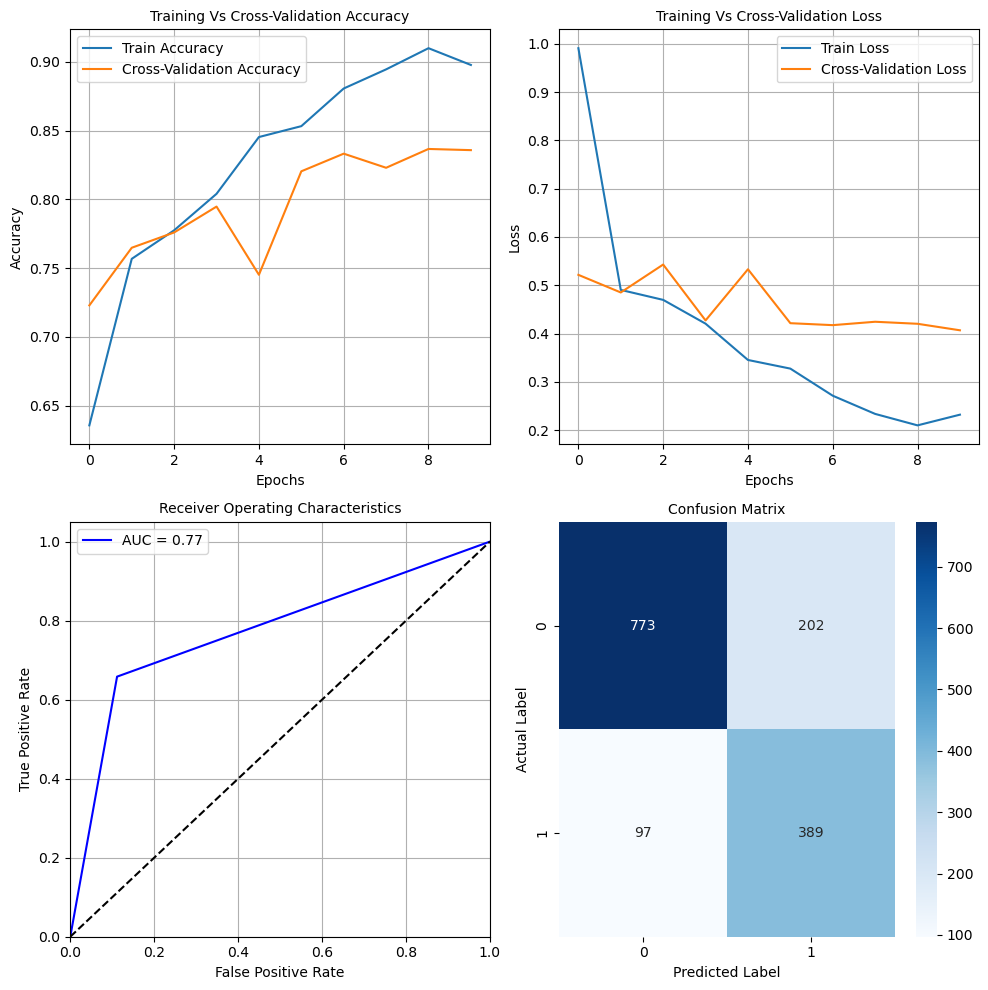

---------------------Classification Report---------------------
              precision    recall  f1-score   support

           0       0.89      0.79      0.84       975
           1       0.66      0.80      0.72       486

    accuracy                           0.80      1461
   macro avg       0.77      0.80      0.78      1461
weighted avg       0.81      0.80      0.80      1461



In [62]:
metrics_tracker(training_accuracy, cross_validation_accuracy,
                   training_loss, cross_validation_loss, y_test, y_predictions)

#### 2.7.6 MobileNetV2

In [63]:
# Loading the MobileNetV2 Model and using transfer learning for our task
headmodel = MobileNetV2(weights = "imagenet", include_top = False,
                 input_shape = (224, 224, 3))
model = headmodel.output
model = AveragePooling2D(pool_size = (2, 2))(model)
model = Flatten(name = 'flatten')(model)
model = Dense(64, activation = 'relu')(model)
model = Dropout(0.3)(model)
model = Dense(32, activation = 'relu')(model)
model = Dropout(0.1)(model)
model = Dense(1, activation = 'sigmoid')(model)

final_model = Model(inputs = headmodel.input, outputs = model)

for layer in headmodel.layers[: -2]:
    layer.trainable = False
    
opt = Adam(lr = 1e-2)
final_model.compile(loss = "binary_crossentropy", optimizer = opt,
                   metrics = ["accuracy"])

final_model.summary()

Model: "functional_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_6[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
______________________________________________________________________________________

In [64]:
fitted_model = final_model.fit(X_train, y_train, epochs = 10, 
                              validation_data = (X_cv, y_cv),
                              batch_size = BATCH_SIZE)

Epoch 1/10
74/74 [==============================] - 14s 190ms/step - loss: 1.1180 - accuracy: 0.6437 - val_loss: 0.5006 - val_accuracy: 0.7476
Epoch 2/10
74/74 [==============================] - 5s 68ms/step - loss: 0.5089 - accuracy: 0.7507 - val_loss: 0.4681 - val_accuracy: 0.7793
Epoch 3/10
74/74 [==============================] - 5s 68ms/step - loss: 0.4474 - accuracy: 0.7905 - val_loss: 0.4328 - val_accuracy: 0.7896
Epoch 4/10
74/74 [==============================] - 5s 72ms/step - loss: 0.3660 - accuracy: 0.8431 - val_loss: 0.4396 - val_accuracy: 0.7853
Epoch 5/10
74/74 [==============================] - 6s 77ms/step - loss: 0.2854 - accuracy: 0.8665 - val_loss: 0.4466 - val_accuracy: 0.8015
Epoch 6/10
74/74 [==============================] - 6s 74ms/step - loss: 0.2333 - accuracy: 0.8906 - val_loss: 0.5289 - val_accuracy: 0.8015
Epoch 7/10
74/74 [==============================] - 6s 82ms/step - loss: 0.2033 - accuracy: 0.9123 - val_loss: 0.4515 - val_accuracy: 0.8212
Epoch 8/10


In [65]:
training_loss = fitted_model.history['loss']
cross_validation_loss = fitted_model.history['val_loss']
training_accuracy = fitted_model.history['accuracy']
cross_validation_accuracy = fitted_model.history['val_accuracy']
y_predictions_raw = final_model.predict(X_test)
y_predictions = zero_one_classifier(y_predictions_raw)

AUC for our classifier is: 0.7867670225800804


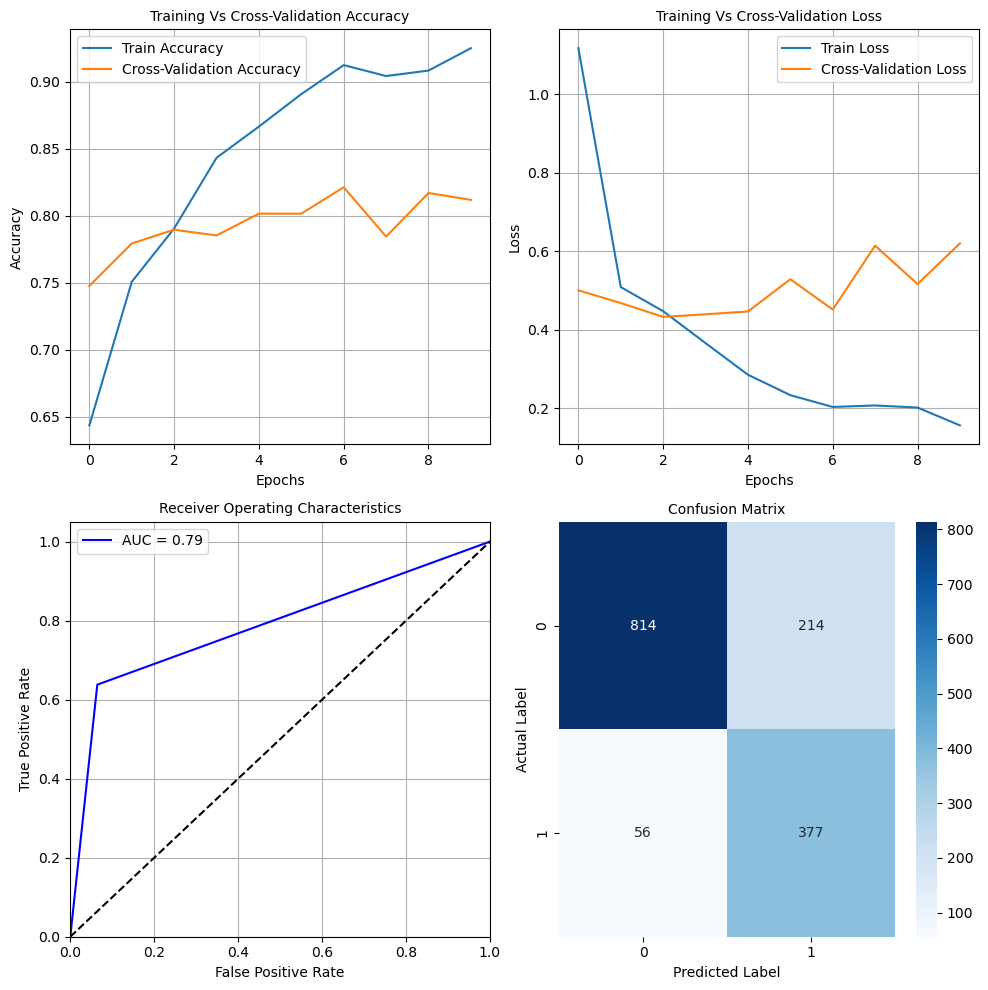

---------------------Classification Report---------------------
              precision    recall  f1-score   support

           0       0.94      0.79      0.86      1028
           1       0.64      0.87      0.74       433

    accuracy                           0.82      1461
   macro avg       0.79      0.83      0.80      1461
weighted avg       0.85      0.82      0.82      1461



In [66]:
metrics_tracker(training_accuracy, cross_validation_accuracy,
                   training_loss, cross_validation_loss, y_test, y_predictions)

#### 2.7.7 ResNet50

In [67]:
# Load the ResNet50 model with pre-trained ImageNet weights
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))

# Freeze the base model layers so they are not updated during training
for layer in base_model.layers:
    layer.trainable = False

# Add a GlobalAveragePooling2D layer and a dense layer to the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)

# Add a final dense layer with a specific number of units and activation function
predictions = Dense(1, activation='sigmoid')(x)

# Create the final model by specifying the inputs and outputs
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "functional_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_7[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________

In [68]:
fitted_model = model.fit(X_train, y_train, epochs = 10, 
                              validation_data = (X_cv, y_cv),
                              batch_size = BATCH_SIZE)

Epoch 1/10
74/74 [==============================] - 17s 235ms/step - loss: 0.6689 - accuracy: 0.5921 - val_loss: 0.6681 - val_accuracy: 0.5962
Epoch 2/10
74/74 [==============================] - 13s 180ms/step - loss: 0.6653 - accuracy: 0.5921 - val_loss: 0.6568 - val_accuracy: 0.6219
Epoch 3/10
74/74 [==============================] - 19s 262ms/step - loss: 0.6553 - accuracy: 0.6045 - val_loss: 0.6597 - val_accuracy: 0.6210
Epoch 4/10
74/74 [==============================] - 27s 363ms/step - loss: 0.6533 - accuracy: 0.6003 - val_loss: 0.6614 - val_accuracy: 0.5971
Epoch 5/10
74/74 [==============================] - 31s 424ms/step - loss: 0.6539 - accuracy: 0.6142 - val_loss: 0.6475 - val_accuracy: 0.6056
Epoch 6/10
74/74 [==============================] - 35s 476ms/step - loss: 0.6496 - accuracy: 0.6152 - val_loss: 0.6468 - val_accuracy: 0.6056
Epoch 7/10
74/74 [==============================] - 34s 466ms/step - loss: 0.6440 - accuracy: 0.6247 - val_loss: 0.6580 - val_accuracy: 0.6108

In [69]:
training_loss = fitted_model.history['loss']
cross_validation_loss = fitted_model.history['val_loss']
training_accuracy = fitted_model.history['accuracy']
cross_validation_accuracy = fitted_model.history['val_accuracy']
y_predictions_raw = model.predict(X_test)
y_predictions = zero_one_classifier(y_predictions_raw)

AUC for our classifier is: 0.5394888849991248


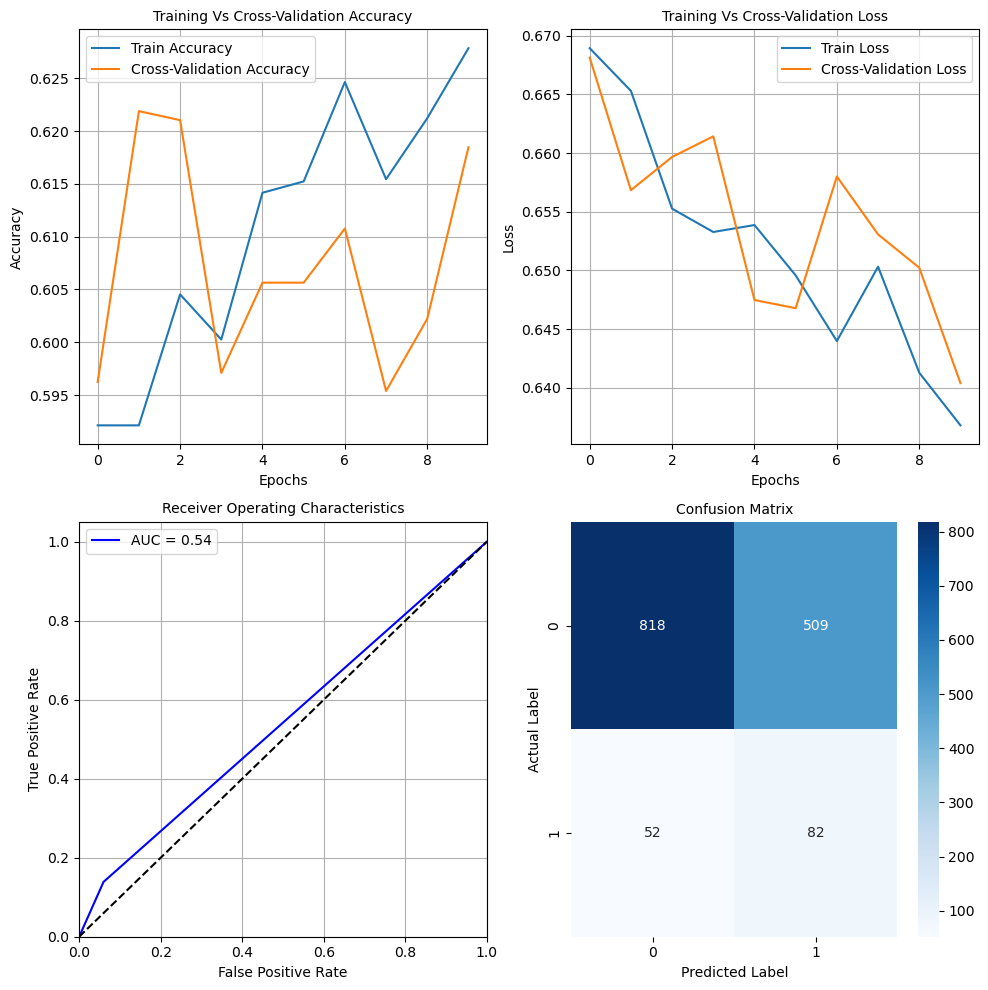

---------------------Classification Report---------------------
              precision    recall  f1-score   support

           0       0.94      0.62      0.74      1327
           1       0.14      0.61      0.23       134

    accuracy                           0.62      1461
   macro avg       0.54      0.61      0.49      1461
weighted avg       0.87      0.62      0.70      1461



In [70]:
metrics_tracker(training_accuracy, cross_validation_accuracy,
                   training_loss, cross_validation_loss, y_test, y_predictions)

### 2.8 Hyperparameter Tuning

#### 2.8.1 Learning Rate

In [71]:
# Loading the MobileNet Model and using transfer learning for our task
headmodel = MobileNet(weights = "imagenet", include_top = False,
                 input_shape = (224, 224, 3))
model = headmodel.output
model = AveragePooling2D(pool_size = (3, 3))(model)
model = Flatten(name = 'flatten')(model)
model = Dense(64, activation = 'relu')(model)
model = Dropout(0.3)(model)
model = Dense(32, activation = 'relu')(model)
model = Dropout(0.1)(model)
model = Dense(1, activation = 'sigmoid')(model)

final_model = Model(inputs = headmodel.input, outputs = model)

for layer in headmodel.layers[: -2]:
    layer.trainable = False
    
opt = Adam(lr = 0.0011)
final_model.compile(loss = "binary_crossentropy", optimizer = opt,
                   metrics = ["accuracy"])

final_model.summary()

Model: "functional_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)    

In [72]:
fitted_model = final_model.fit(X_train, y_train, epochs = 10, 
                              validation_data = (X_cv, y_cv),
                              batch_size = BATCH_SIZE)

Epoch 1/10
74/74 [==============================] - 14s 185ms/step - loss: 0.5938 - accuracy: 0.6889 - val_loss: 0.4862 - val_accuracy: 0.7673
Epoch 2/10
74/74 [==============================] - 5s 72ms/step - loss: 0.4469 - accuracy: 0.7901 - val_loss: 0.3922 - val_accuracy: 0.8272
Epoch 3/10
74/74 [==============================] - 5s 71ms/step - loss: 0.3700 - accuracy: 0.8376 - val_loss: 0.3635 - val_accuracy: 0.8349
Epoch 4/10
74/74 [==============================] - 5s 73ms/step - loss: 0.3188 - accuracy: 0.8652 - val_loss: 0.3782 - val_accuracy: 0.8289
Epoch 5/10
74/74 [==============================] - 6s 83ms/step - loss: 0.2868 - accuracy: 0.8787 - val_loss: 0.3587 - val_accuracy: 0.8417
Epoch 6/10
74/74 [==============================] - 6s 85ms/step - loss: 0.2262 - accuracy: 0.9071 - val_loss: 0.3646 - val_accuracy: 0.8486
Epoch 7/10
74/74 [==============================] - 7s 93ms/step - loss: 0.1971 - accuracy: 0.9206 - val_loss: 0.3428 - val_accuracy: 0.8546
Epoch 8/10


In [73]:
training_loss = fitted_model.history['loss']
cross_validation_loss = fitted_model.history['val_loss']
training_accuracy = fitted_model.history['accuracy']
cross_validation_accuracy = fitted_model.history['val_accuracy']
y_predictions_raw = final_model.predict(X_test)
y_predictions = zero_one_classifier(y_predictions_raw)

AUC for our classifier is: 0.8461899760779509


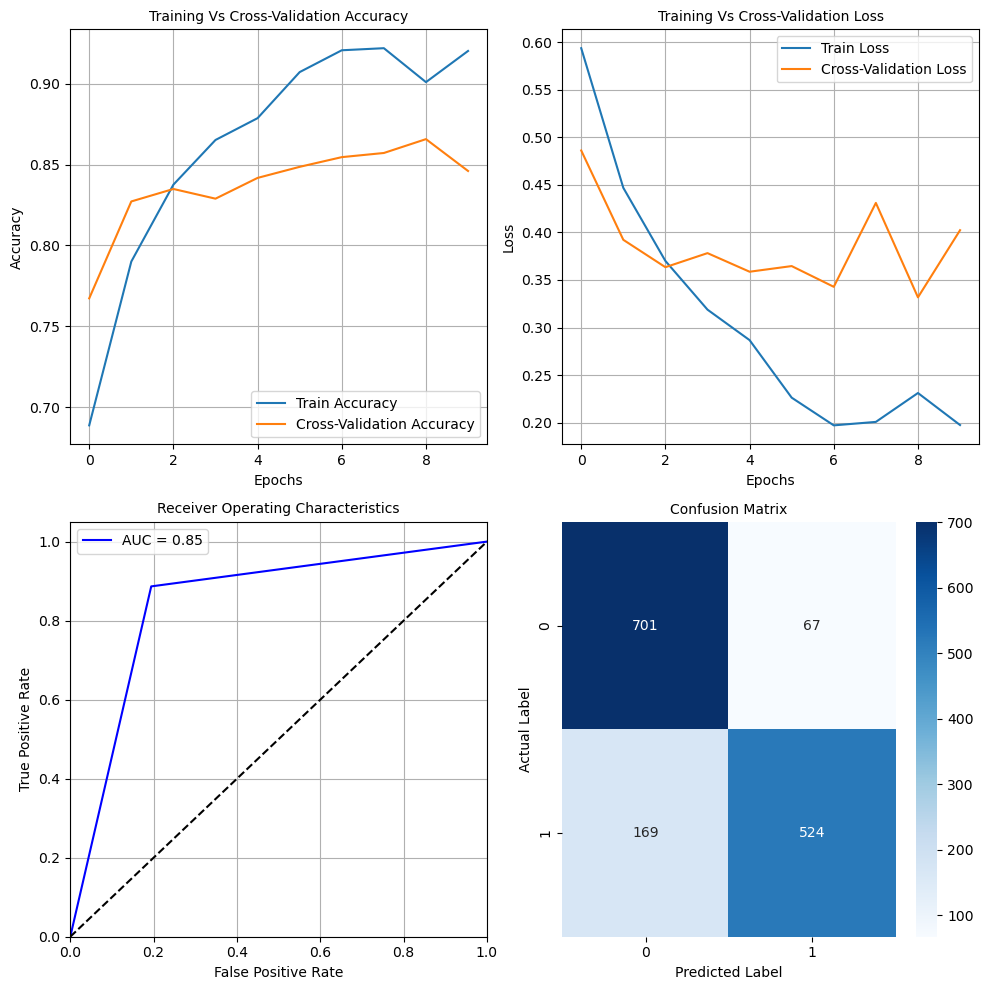

---------------------Classification Report---------------------
              precision    recall  f1-score   support

           0       0.81      0.91      0.86       768
           1       0.89      0.76      0.82       693

    accuracy                           0.84      1461
   macro avg       0.85      0.83      0.84      1461
weighted avg       0.84      0.84      0.84      1461



In [74]:
metrics_tracker(training_accuracy, cross_validation_accuracy,
                   training_loss, cross_validation_loss, y_test, y_predictions)

#### 2.8.2 Batch Size

In [75]:
# Loading the MobileNet Model and using transfer learning for our task
headmodel = MobileNet(weights = "imagenet", include_top = False,
                 input_shape = (224, 224, 3))
model = headmodel.output
model = AveragePooling2D(pool_size = (3, 3))(model)
model = Flatten(name = 'flatten')(model)
model = Dense(64, activation = 'relu')(model)
model = Dropout(0.3)(model)
model = Dense(32, activation = 'relu')(model)
model = Dropout(0.1)(model)
model = Dense(1, activation = 'sigmoid')(model)

final_model = Model(inputs = headmodel.input, outputs = model)

for layer in headmodel.layers[: -2]:
    layer.trainable = False
    
opt = Adam(lr = 0.0011)
final_model.compile(loss = "binary_crossentropy", optimizer = opt,
                   metrics = ["accuracy"])

final_model.summary()

Model: "functional_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)    

In [76]:
fitted_model = final_model.fit(X_train, y_train, epochs = 10, 
                              validation_data = (X_cv, y_cv),
                              batch_size = BATCH_SIZE + 64)

Epoch 1/10
37/37 [==============================] - 12s 314ms/step - loss: 0.7503 - accuracy: 0.5949 - val_loss: 0.5140 - val_accuracy: 0.7425
Epoch 2/10
37/37 [==============================] - 4s 122ms/step - loss: 0.4738 - accuracy: 0.7719 - val_loss: 0.4292 - val_accuracy: 0.8041
Epoch 3/10
37/37 [==============================] - 5s 132ms/step - loss: 0.4007 - accuracy: 0.8245 - val_loss: 0.4466 - val_accuracy: 0.8058
Epoch 4/10
37/37 [==============================] - 5s 140ms/step - loss: 0.3290 - accuracy: 0.8592 - val_loss: 0.3584 - val_accuracy: 0.8400
Epoch 5/10
37/37 [==============================] - 5s 143ms/step - loss: 0.2933 - accuracy: 0.8744 - val_loss: 0.4440 - val_accuracy: 0.8238
Epoch 6/10
37/37 [==============================] - 6s 151ms/step - loss: 0.2487 - accuracy: 0.8994 - val_loss: 0.3559 - val_accuracy: 0.8443
Epoch 7/10
37/37 [==============================] - 6s 175ms/step - loss: 0.1990 - accuracy: 0.9215 - val_loss: 0.3335 - val_accuracy: 0.8580
Epoch

In [77]:
training_loss = fitted_model.history['loss']
cross_validation_loss = fitted_model.history['val_loss']
training_accuracy = fitted_model.history['accuracy']
cross_validation_accuracy = fitted_model.history['val_accuracy']
y_predictions_raw = final_model.predict(X_test)
y_predictions = zero_one_classifier(y_predictions_raw)

In [78]:
metrics_tracker(training_accuracy, cross_validation_accuracy,
                   training_loss, cross_validation_loss, y_test, y_predictions)

AUC for our classifier is: 0.8562197327732073


---------------------Classification Report---------------------
              precision    recall  f1-score   support

           0       0.91      0.87      0.89       914
           1       0.80      0.86      0.83       547

    accuracy                           0.87      1461
   macro avg       0.86      0.87      0.86      1461
weighted avg       0.87      0.87      0.87      1461



### 2.9 Saving the Best Model

In [79]:
# Saving the best hyperparameter tuned model
final_model.save('Models/Mobilenet.h5')

### 3. Summary

As we performed a lot of experimentation about selecting the best pre-trained architecture to be used for solar panels dust detection, it is seen that __MobileNet__ was performing the best. 

After selecting the MobileNet architecture, essential hyperparameter tuning was performed and finally, this model was saved in the __Models__ directory for inference. 

After performing these steps, we would take the remaining steps as follows

1. Build a __Flask__ or __Fastapi__ that leverages a web-framework for generating streaming and batch predictions of solar panels.
2. We would be taking steps to integrate the best model in __camera__, leading to on-demand model predictions. 
3. Constant __monitoring__ of model performance would be done and if there is any distribution shift in data, the team would be alerted to further train the models or to change the feature engineering steps to improve model performance on unseen data points. 